# 泰坦尼克号数据分析

## 1. 介绍

泰坦尼克号数据：包括泰坦尼克号上 2224 名乘客和船员中 891 名的人口学数据和乘客基本信息。你可以右键点击 [该链接](https://raw.githubusercontent.com/ShiChJ/DAND-Basic-Materials/master/P2/Project_Files/titanic-data.csv) 选择“另存为”下载。你也可以在 [Kaggle](https://www.kaggle.com/c/titanic/data) 网站上查看这个数据集的详细描述。这个数据集就是来自 Kaggle。

目的是根据数据集的内容，分析有哪些因素会影响船上人的生还率？


## 2. 读取数据

In [58]:
import pandas as pd

#读取预览数据
titanic_df = pd.read_csv('titanic-data.csv')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 3 处理冗余数据

### 3.1 初步分析原始数据

In [59]:
# 计算缺失的数据
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

原始数据在Age, Cabin, Embarked这三个值中有缺失的数据,

由于变量Cabin缺失太多，为了避免误差影响判断，去掉Cabin变量

下面对Age Embarked数据进行处理,并删除不必要的列

In [60]:
# 删除用不上的Name 和 Cabin变量
titanic_df = titanic_df.drop(['Name','Cabin','Ticket'], axis=1)

titanic_df = titanic_df.dropna()

print(titanic_df.isnull().sum())

titanic_df.info()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Sex            712 non-null object
Age            712 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Fare           712 non-null float64
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 55.6+ KB


In [61]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 4. 数据转换

### 4.1 根据观察原始数据，Sex是文本，需要转换成值类型， 

In [62]:
titanic_df['Sex'] = titanic_df['Sex'].replace({'male':1, 'female':2})

titanic_df.head(n=8)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,S
1,2,1,1,2,38.0,1,0,71.2833,C
2,3,1,3,2,26.0,0,0,7.9250,S
3,4,1,1,2,35.0,1,0,53.1000,S
4,5,0,3,1,35.0,0,0,8.0500,S
6,7,0,1,1,54.0,0,0,51.8625,S
7,8,0,3,1,2.0,3,1,21.0750,S
8,9,1,3,2,27.0,0,2,11.1333,S


### 4.2 家庭成员的数量要根据SibSp和Parch的和进行计算

In [63]:
titanic_df['FamilySize'] = titanic_df['SibSp']+titanic_df['Parch']

titanic_df.head(n=8)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,1,0,3,1,22.0,1,0,7.2500,S,1
1,2,1,1,2,38.0,1,0,71.2833,C,1
2,3,1,3,2,26.0,0,0,7.9250,S,0
3,4,1,1,2,35.0,1,0,53.1000,S,1
4,5,0,3,1,35.0,0,0,8.0500,S,0
6,7,0,1,1,54.0,0,0,51.8625,S,0
7,8,0,3,1,2.0,3,1,21.0750,S,4
8,9,1,3,2,27.0,0,2,11.1333,S,2


## 5. 分析数据

从三个方面分析

第一个性别

第二个舱室级别

第三个家庭成员


Populating the interactive namespace from numpy and matplotlib


Text(0.5,1,'Sex and survived')

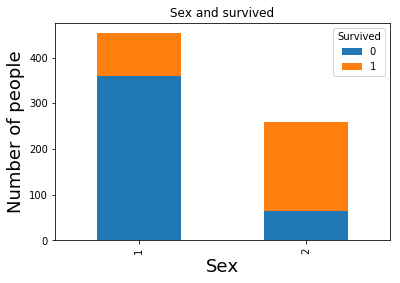

In [64]:
from matplotlib import pyplot as plt
%pylab inline

# 可视化性别生还数据
gp = titanic_df.groupby(["Sex","Survived"])["Survived"].count().unstack().plot(kind="bar",stacked="True")
plt.xlabel('Sex',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('Sex and survived')

根据上图分析结果

女性的幸存率高于男性

Text(0.5,1,'Ticket class and survived')

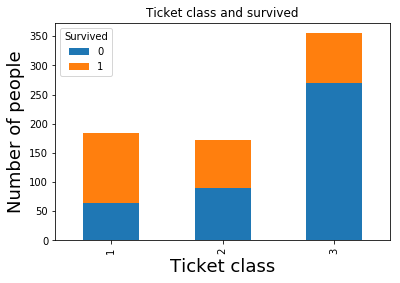

In [65]:
# 可视化船舱级别生还数据
gp = titanic_df.groupby(["Pclass","Survived"])["Survived"].count().unstack().plot(kind="bar",stacked="True")
plt.xlabel('Ticket class',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('Ticket class and survived')

船票的级别越高生存率越高（1st class代表高等舱 ）

Text(0.5,1,'FamilySize and survived')

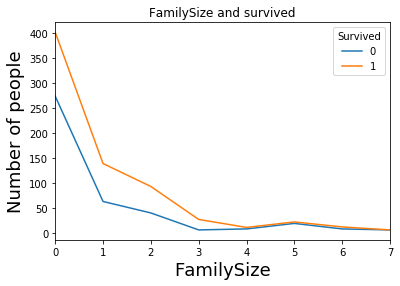

In [66]:
# 可视化家庭成员生还数据
gp = titanic_df.groupby(["FamilySize","Survived"])["Survived"].count().unstack().plot(kind="line",stacked="True")
plt.xlabel('FamilySize',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('FamilySize and survived')

家庭成员越少的生存几率越高

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


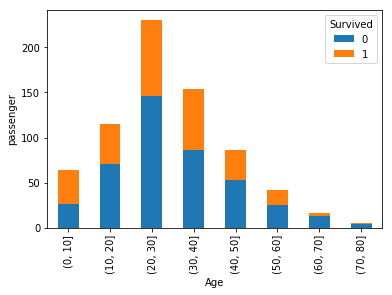

In [67]:
# 可视化不同年龄段的生还情况
Age_Survived = titanic_df[['Age','Survived']]
Age_Survived['i'] = pd.cut(Age_Survived['Age'], np.arange(0,100,10))
Age_Survived.groupby(['i','Survived'])['Survived'].count().unstack().plot(kind='bar',stacked=True)
plt.xlabel('Age')
plt.ylabel('passenger')
plt.show()

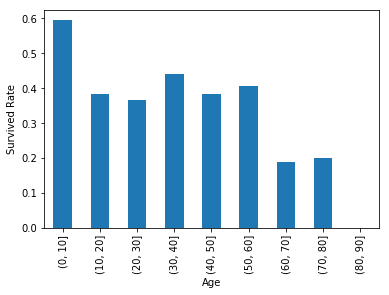

In [68]:
# 可视化不同年龄段生还概率
Age_Survived.groupby('i')['Survived'].mean().plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Survived Rate')
plt.show()

根据上图分析结果, 0~10岁的孩子生存几率最高

In [69]:
print('性别相关性：%s'%corrcoef(titanic_df['Survived'],titanic_df['Sex']))

print('船票级别相关性：%s'%corrcoef(titanic_df['Survived'],titanic_df['Pclass']))

print('家庭成员相关性：%s'%corrcoef(titanic_df['Survived'],titanic_df['FamilySize']))

print('年龄相关性：%s'%corrcoef(titanic_df['Survived'],titanic_df['Age']))


性别相关性：[[ 1.          0.53676162]
 [ 0.53676162  1.        ]]
船票级别相关性：[[ 1.         -0.35646159]
 [-0.35646159  1.        ]]
家庭成员相关性：[[ 1.          0.04506766]
 [ 0.04506766  1.        ]]
年龄相关性：[[ 1.         -0.08244587]
 [-0.08244587  1.        ]]


说明性别有正向相关性，女性高于男性（这里男性是1女性是2）

船票级别有相关性，程负相关，级别越低，幸存率越低

家庭成员数越小，生存率越高，相关性很小

年龄越小生存几率越高，但相关性很小

# 6. 总结

女性生存率高于男性

船票级别越高生还率越高

家庭成员越少生还率越高，但相关性很小

本次分析是基于此次数据的描述、统计和展现，不代表因果关系
因为Age变量进行了缺失赋值，可能影响结果误差
本次分析只分析了性别、船票级别和家庭成员三个因素，还有其他因素可能影响生还率